In [170]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import plotly.express as px
import joblib

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [99]:
data = pd.read_csv(r"D:\\USL\\USL Case study\\Country-data.csv")

In [100]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [101]:
data.shape

(167, 10)

In [102]:
data.info

<bound method DataFrame.info of                  country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2      

# Lets explore the data

In [103]:
data.shape

(167, 10)

In [104]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


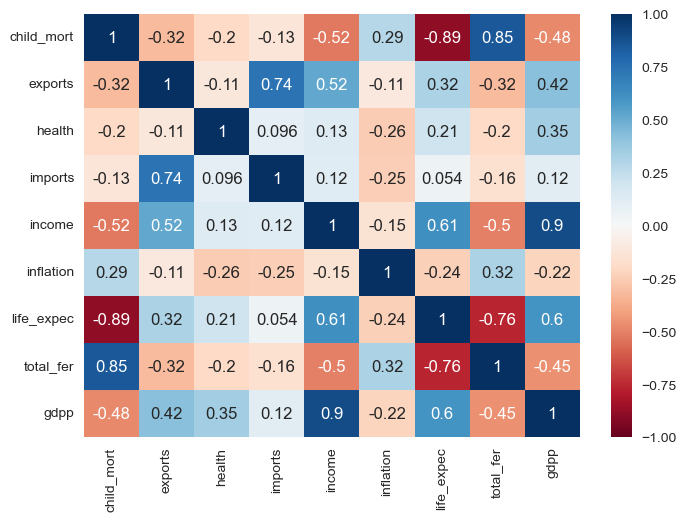

In [105]:
# Correlation heatmap

sns.heatmap(data.corr(numeric_only=True),annot=True,vmin=-1,cmap='RdBu')
plt.show()

# Visualization of the data

In [106]:
# Befor we begin visualization lets convert country to index (As it is redundant column)

data.set_index('country',inplace=True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


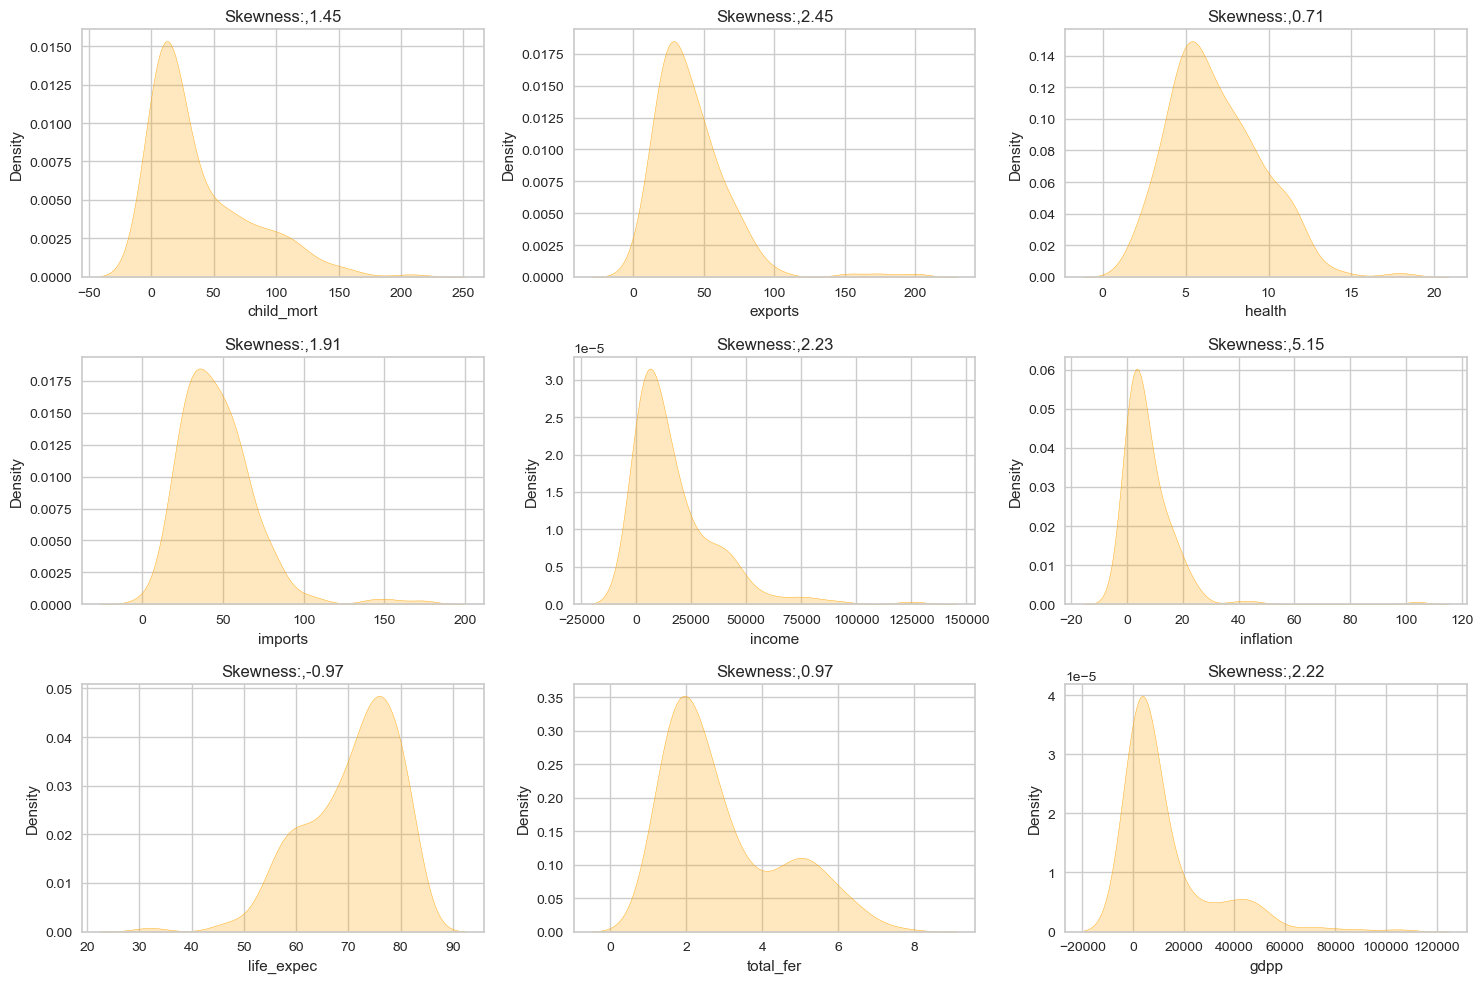

In [107]:
# Univariate Analysis

t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='orange')
    plt.title(f'Skewness:,{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

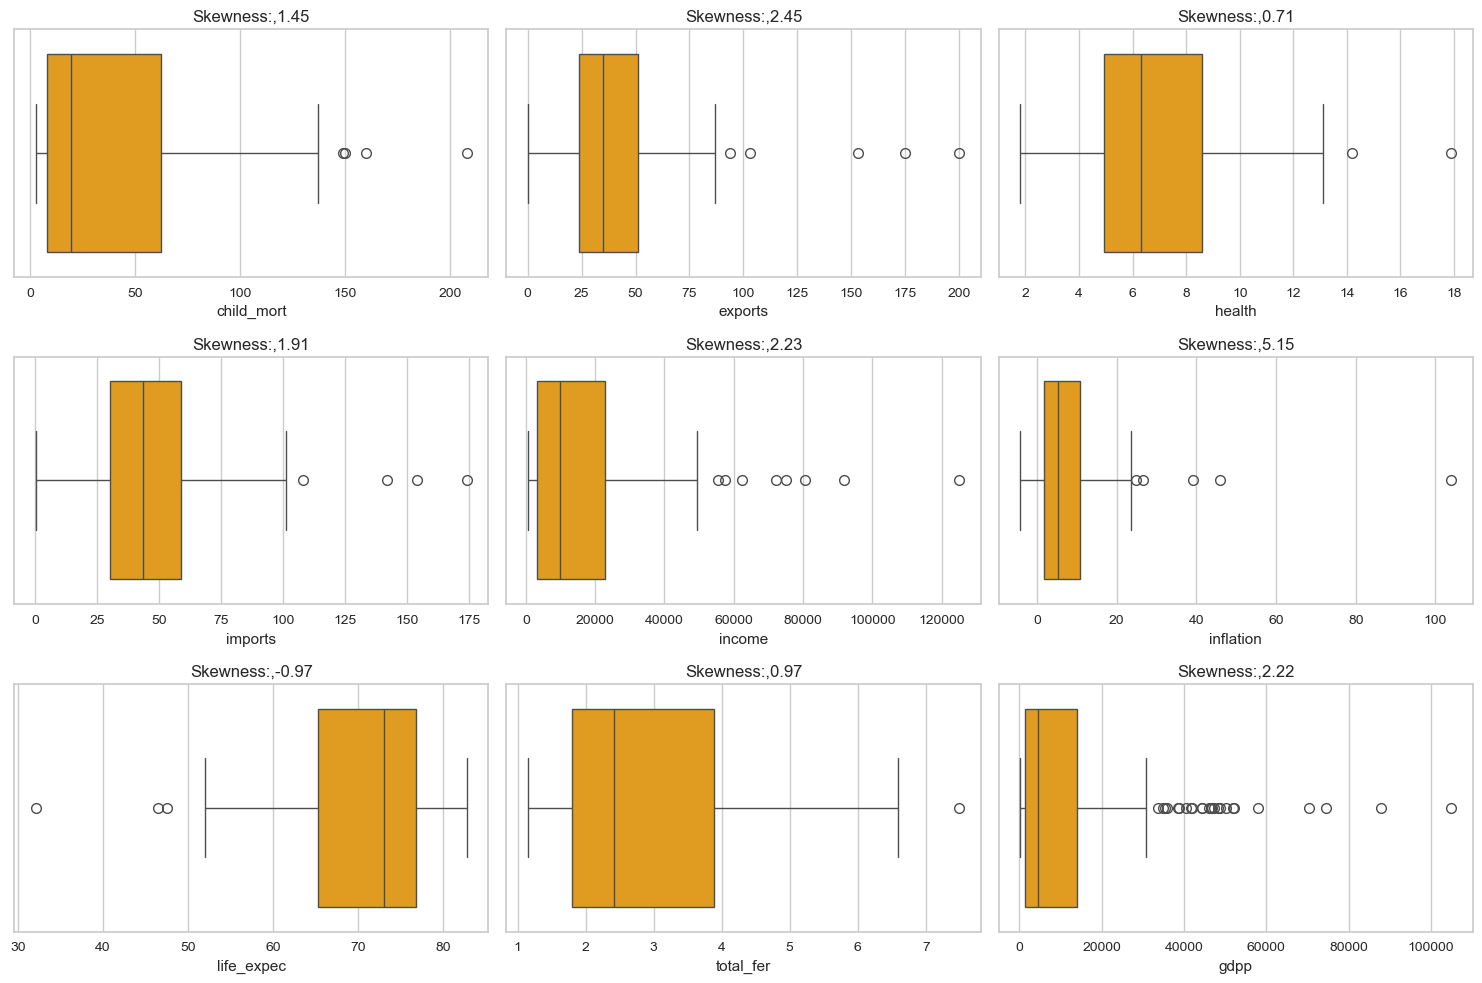

In [108]:
# Univariate Analysis

t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='orange')
    plt.title(f'Skewness:,{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

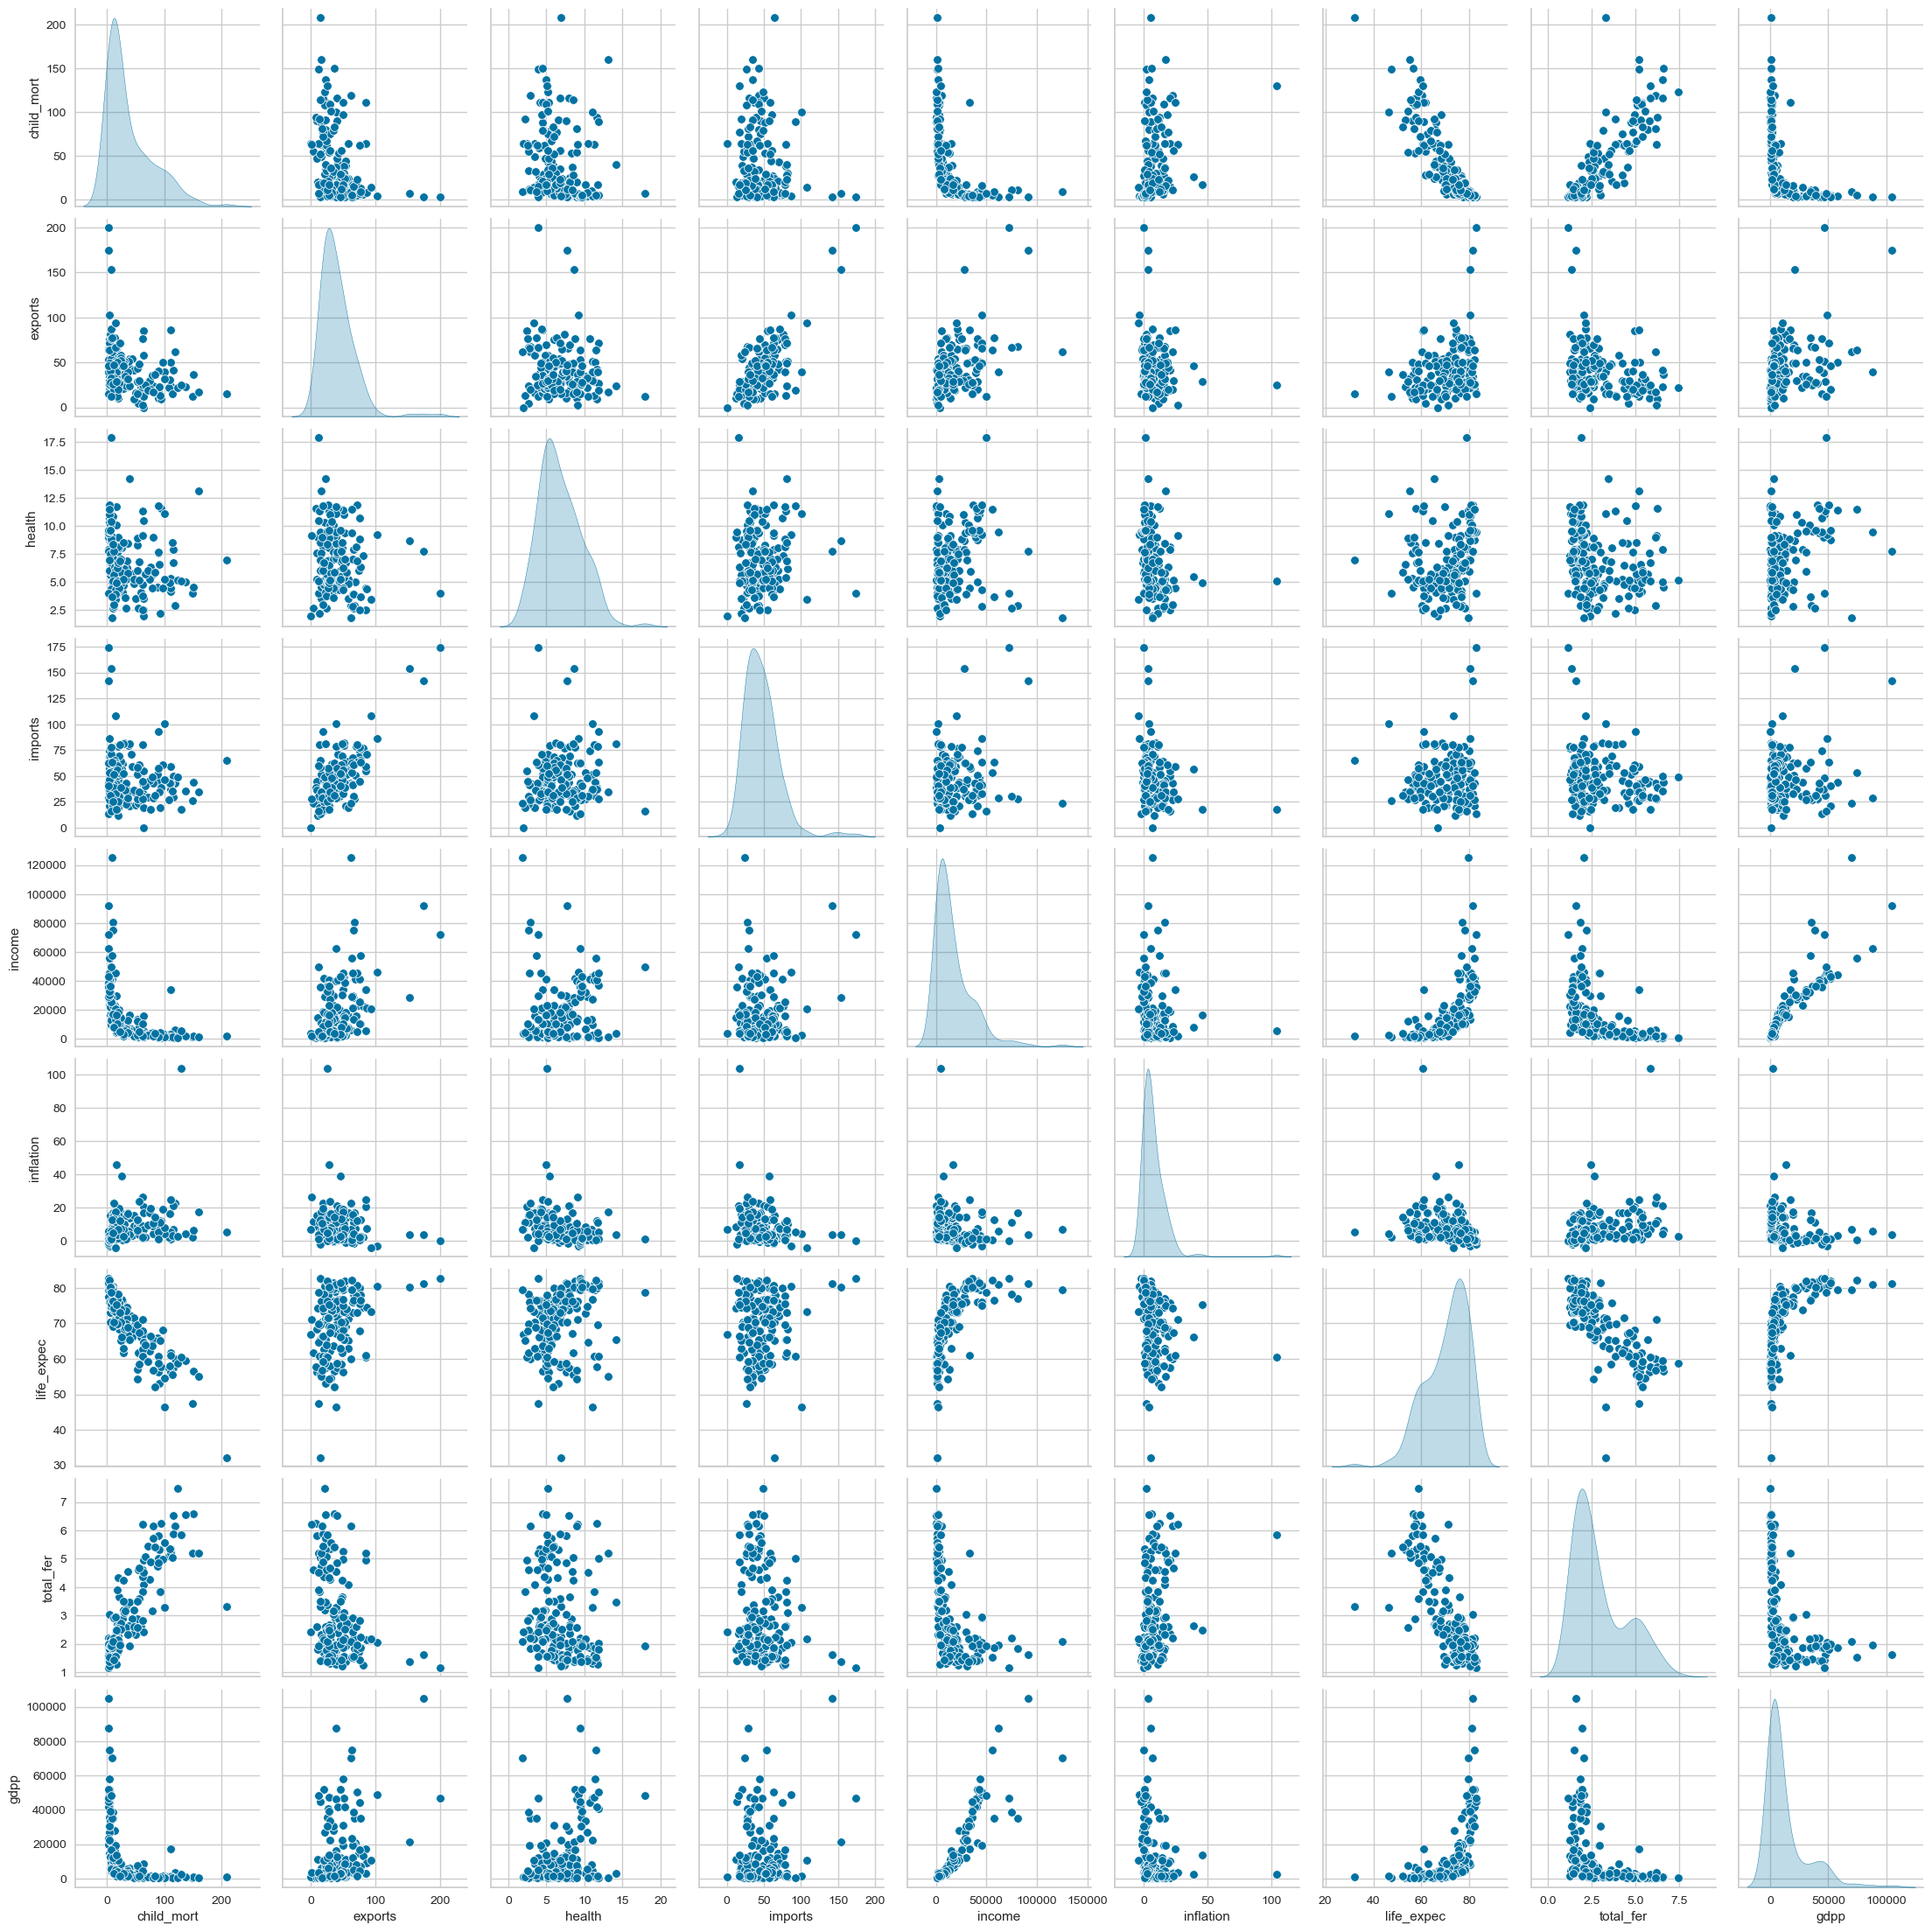

In [109]:
# Multivariate Analysis

sns.pairplot(data,diag_kind='kde')
plt.show()

# Data Preprocessing

In [110]:
# Check for missing values

data.isnull().sum().sum()

# No missing values 

np.int64(0)

In [111]:
# Treat the extreme outliers
# We will go with capping using IQR and in order to cap on the extreme one's lets keep wishker lenth = 2.5

for i in data.columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr = q3 - q1

    ul,ll = q3 + 2.5*iqr, q1 - 2.5*iqr
    data[i] = data[i].apply(lambda x: ul if x > ul else ll if x < ll else x)

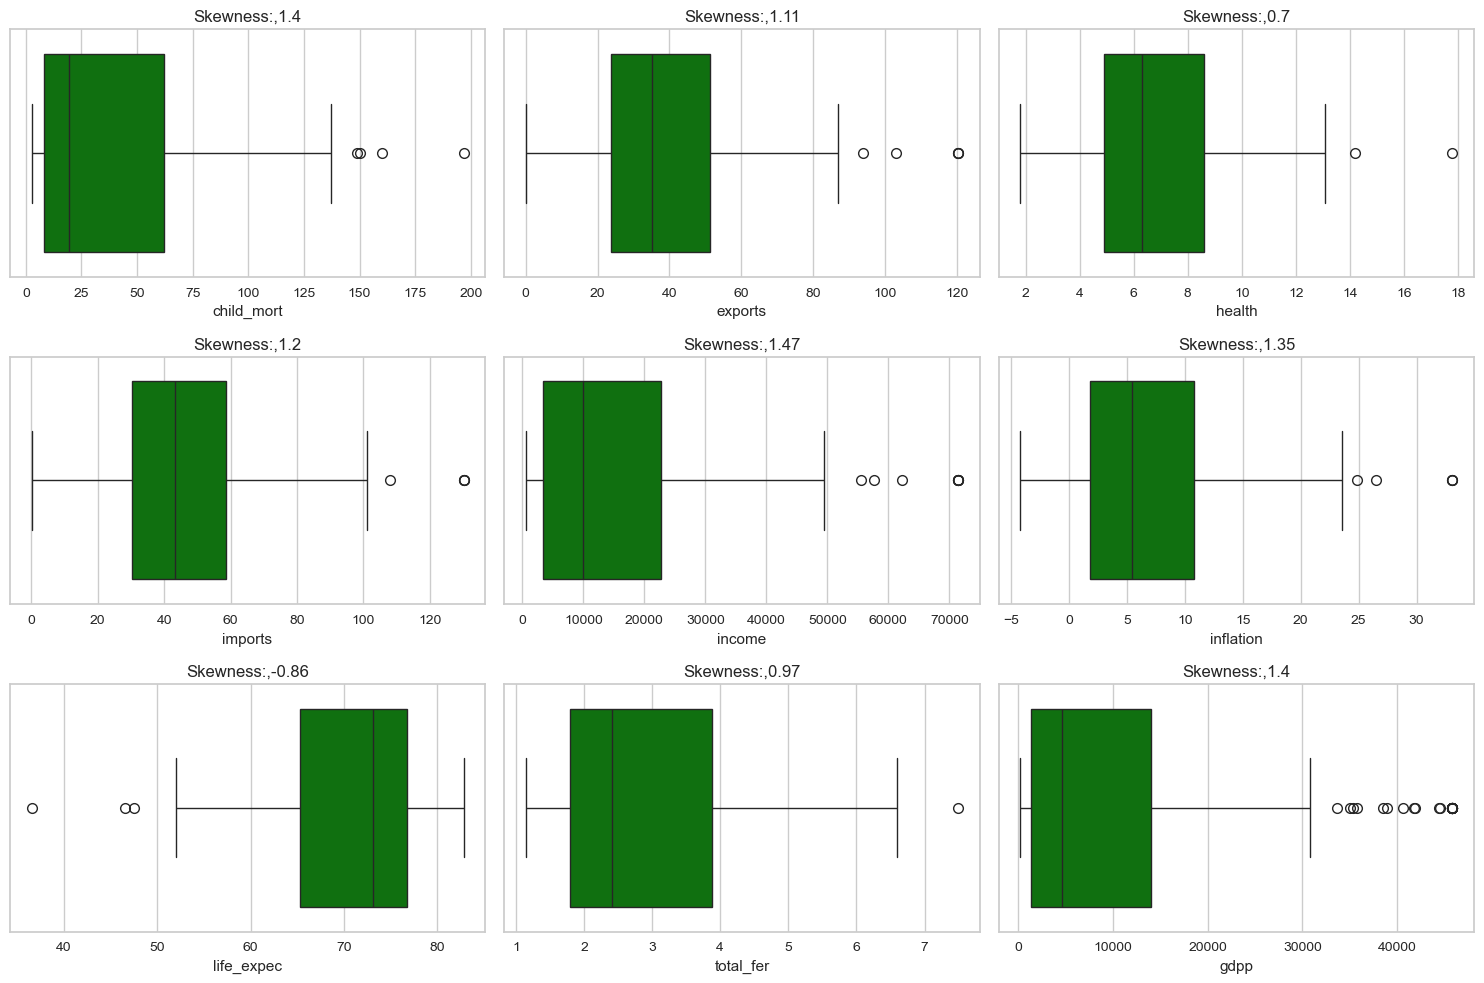

In [112]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='green')
    plt.title(f'Skewness:,{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [113]:
# Lets apply PCA on the data before we proceed with clustering. Just have better visaulization and better clustering.
# In PCA we need to pass standarized data. So lets import the function from liberaries

# Lets create and instance of scalling 

scaler = StandardScaler()

# Also lets create an instance for PCA

pca = PCA(n_components=5,random_state=2)

# Lets create pipeline for the above two processes

pipeline = Pipeline([('Scale',scaler),('PCA',pca)])

In [114]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=2))])

In [115]:
pca.explained_variance_ratio_.cumsum()

# At n_components = 5 we are able to explain ~ 95% of variance, which is good enough.
# So 9 dimension data can be reduce to 5 dimension

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697])

In [116]:
final_data = pipeline.transform(data)

In [117]:
# tranform return the array, so lets covert it into dataframe

final_data = pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5'],index=data.index)
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119


# K-Mean Clustering

In [118]:
# Identify the valye of k

kelbow = KElbowVisualizer(estimator=KMeans(random_state=2),k=10)

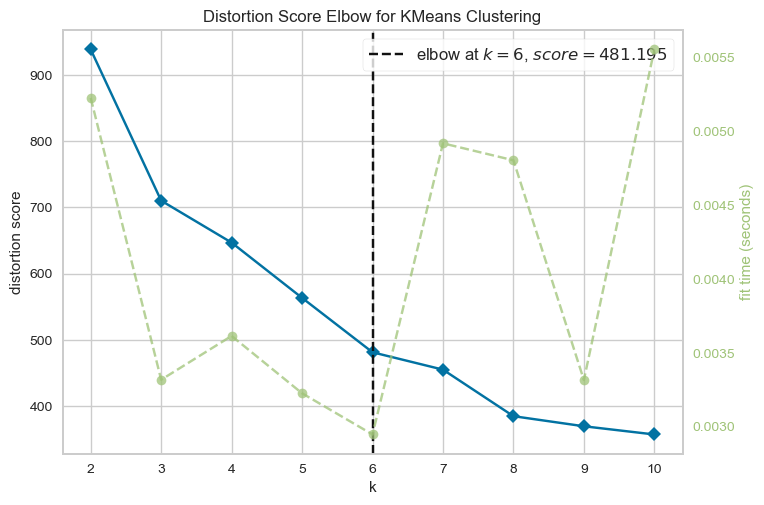

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [119]:
kelbow.fit(final_data)
kelbow.show()

Although the above chart marks the elbow at k=6 but we can see the significant drop in distortion score from k=2 to k=3. As we increase the number of cluster it might become over fitted so lets explore the silhouette visualizer to identify the correct or more generalized value of k.

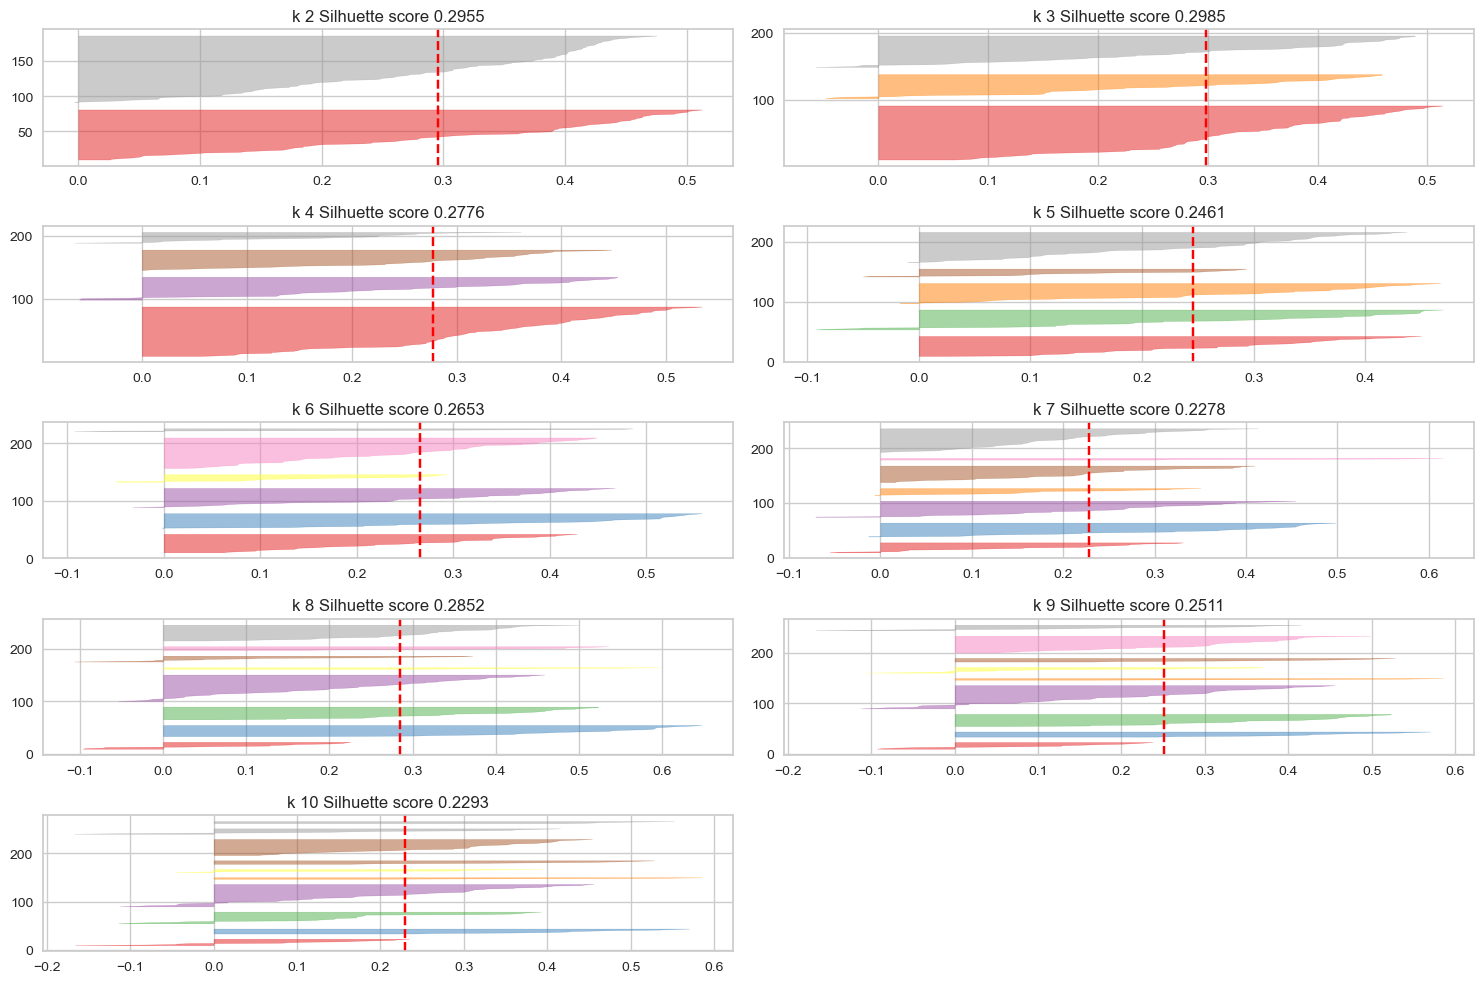

In [120]:
t =1
plt.figure(figsize=(15,10))
for i in range(2,11):
    plt.subplot(5,2,t)
    model = KMeans(n_clusters=i,random_state=2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'k {i} Silhuette score {round(sil_viz.silhouette_score_,4)}')
    t+=1
plt.tight_layout()
plt.show()

After analyzing the Elbow plot and Silhouette visualizer lets go with k=3. Although there are few datapoints that have been misclassified, but we see no drop in Silhouette score and ther is good enough data in every cluster. Also from k-elbow plot significant drop in WCSS (Distortion score) was observed from k=2 to k=3.

In [121]:
final_kmeans = KMeans(n_clusters=3,random_state=2)


In [122]:
labels = final_kmeans.fit_predict(final_data)

In [124]:
# Lets check the Silhouette score

print('Silhouette Score:',silhouette_score(final_data,labels))

Silhouette Score: 0.2984578234829661


In [125]:
# Lets put these labels on PCA data

final_data['Labels'] = labels
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5,Labels
country,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,2
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0


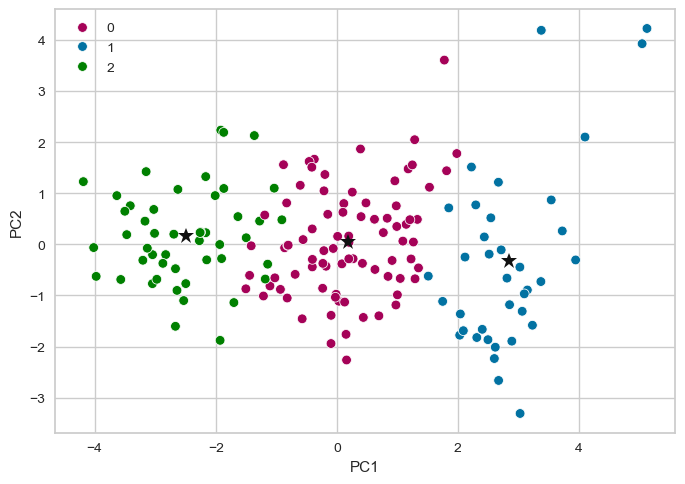

In [127]:
# Lets Visualize the clusters
# In order to get the best visualization lets choose PC1 and PC2 as they maximum variance  

centroids = final_kmeans.cluster_centers_
centroids

sns.scatterplot(data=final_data,x='PC1',y='PC2',palette=['m','b','green'],hue=labels)
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=12,color='k')
plt.show()

# Business Interpretations

In [129]:
# To have business understanding lets put the labels on the original dataset

data['Label'] = labels
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0
Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,2
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,0


In [130]:
data.groupby(by='Label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Label,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405
2,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667


After studying the above data we can conclude that countries that have been assigned in cluster 2 can be called under developing, while cluster 1 are developed. Countries belonging to cluster 0 are doing average in most of the factors but struggeling in the econo0mic factors like gdpp, income and expenditure on health. Hence they can called developing.

In [133]:
data['Label'] = data['Label'].map({0:'Developing',1:'Developed',2:'Underdeveloped'})

In [134]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,Underdeveloped
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,Developing
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,Developing
Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,Underdeveloped
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,Developing


In [135]:
# Developed Countries

data[data['Label'] == 'Developed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

In [ ]:
# Developing Countries

data[data['Label'] == 'Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles',
       'Solomon Islands', 'Sri Lanka', 'St. Vincent and the Grenadines',
       'Suriname', 'Tajikistan', '

In [ ]:
# Underdeveloped Countries

data[data['Label'] == 'Underdeveloped'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

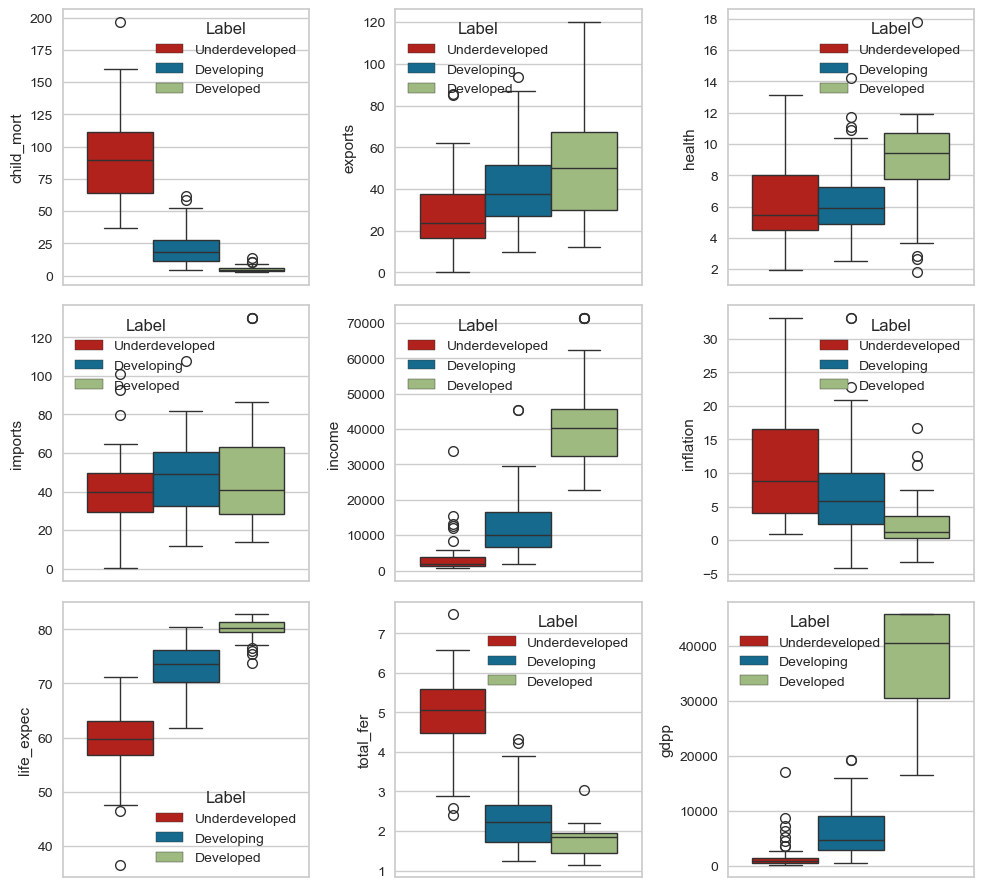

In [155]:
t=1
plt.figure(figsize=(10,12))
for i in data.columns:
    if i != 'Label':
        plt.subplot(4,3,t)
        sns.boxplot(data=data,y=i,hue='Label',palette=['r','b','g'])
        t+=1
plt.tight_layout()
plt.show()

In [158]:
# World Map

px.choropleth(data_frame=data,locationmode='country names',
              locations=data.index,color='Label',
              color_discrete_map={'Underdeveloped':'red',
                                'Developing':'blue',
                                'Developed':'green'})

In [163]:
input_data = data.iloc[0,:-1].values
input_data

array([np.float64(90.2), np.float64(10.0), np.float64(7.58),
       np.float64(44.9), np.float64(1610.0), np.float64(9.44),
       np.float64(56.2), np.float64(5.82), np.float64(553.0)],
      dtype=object)

In [164]:
final_input_data = pipeline.transform([input_data])

In [166]:
final_kmeans.predict(final_input_data)[0]

np.int32(2)

In [168]:
# Lets create a joblib file of pipeline

with open('pipeline.joblib','wb') as file:
    joblib.dump(pipeline,file)

In [169]:
# Lets create a joblib file of model

with open('model.joblib','wb') as file:
    joblib.dump(final_kmeans,file)